In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import numpy as np
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.initializers import RandomNormal  
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization

weight_decay  = 0.0001# 新增
batch_size    = 512
epochs        = 500
#iterations    = 391
num_classes   = 100
dropout       = 0.2
log_filepath  = '/content/drive/MyDrive/ECE6930/NiN-0207-02/new1'


In [ ]:
def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    return x_train, x_test

def scheduler(epoch):
    if epoch <= 80:
        return 0.001
    if epoch <= 140:
        return 0.0005
    return 0.0001


In [ ]:
def build_model():
    model = Sequential()

    model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), 
                     input_shape=x_train.shape[1:]))# 32, 32, 3
    model.add(Activation('relu'))
    model.add(Conv2D(160, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))

    model.add(Dropout(dropout))
    
    model.add(Conv2D(192, (5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1),padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same'))

    model.add(Dropout(dropout))

    model.add(Conv2D(192, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(100, (1, 1), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay)))
    model.add(Activation('relu'))

    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))

    sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes) # one-hot 编码
y_test = keras.utils.to_categorical(y_test, num_classes) # one-hot 编码
x_train, x_test = color_preprocessing(x_train, x_test) # 把减均值，除以标准差封装成了函数


169001437/169001437 [==============================] - 80s 0us/step


In [ ]:
model = build_model()
print(model.summary())
import os
# set callback
save_dir = '/content/drive/MyDrive/ECE6930/NiN-0207-02/new1'
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
checkpointer = keras.callbacks.ModelCheckpoint(os.path.join(save_dir, '{epoch:03d}.h5'), monitor='val_loss', verbose=0,						save_best_only=False, 
 								save_weights_only=False, mode='auto', 
 								period=10)



# set data augmentation
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
datagen.fit(x_train)

# start training
history = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                    #steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=[checkpointer],
                    validation_data=(x_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 192)       14592     
                                                                 
 activation (Activation)     (None, 32, 32, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 160)       30880     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 160)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 96)        15456     
                                                                 
 activation_2 (Activation)   (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 96)       0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Using real-time data augmentation.
Epoch 1/500
98/98 [==============================] - 44s 306ms/step - loss: 4.5738 - accuracy: 0.0301 - val_loss: 4.4149 - val_accuracy: 0.0592
Epoch 2/500
98/98 [==============================] - 29s 294ms/step - loss: 4.2926 - accuracy: 0.0752 - val_loss: 4.1874 - val_accuracy: 0.0891
Epoch 3/500
98/98 [==============================] - 29s 295ms/step - loss: 4.0895 - accuracy: 0.1105 - val_loss: 3.9972 - val_accuracy: 0.1280
Epoch 4/500
98/98 [==============================] - 30s 307ms/step - loss: 3.9435 - accuracy: 0.1361 - val_loss: 3.8265 - val_accuracy: 0.1527
Epoch 5/500
98/98 [==============================] - 28s 287ms/step - loss: 3.7988 - accuracy: 0.1558 - val_loss: 3.7228 - val_accuracy: 0.1733
Epoch 6/500
98/98 [==============================] - 28s 288ms/step - loss: 3.7014 - accuracy: 0.1746 - val_loss: 3.6533 - val_accuracy: 0.1862
Epoch 7/500
98/98 [==============================] - 28s 289ms/step - loss: 3.5844 - accuracy: 0

In [ ]:
# save model
model.save('nin.h5')


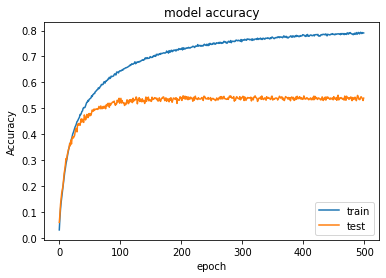

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train","test"],loc="lower right")
plt.show()
